#Fun with MNIST
Convolutional Neural Networks (CNNs) are able to solve a wide range of computer vision tasks. In this Lab you will learn about

- Image classification
- Convolutional AutoEncoders
- Denoising AutoEncoders
- Image super resolution
- Image regression
- Image segmentation
- Object detection
- Few-shot learning with Siamese networks
- Generative Adversarial Networks (GANs)

The purpose of the Lab is to give your some intuition about how to tweak CNNs to solve different tasks.

**Before we start - remember to set runtime to GPU**

##Task 1: Downloading and pre-processing the MNIST dataset
The MNIST dataset of handwritten digits is so commonly used that it comes with most deep learning frameworks, including Keras. Let's download the dataset and explore a little bit.

In [1]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras import backend as K

num_classes = 10

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# Pre-process inputs
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class indices to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

11493376/11490434 [==============================] - 0s 0us/step


###Questions 1.1
1. What is the input shape?
2. How many training examples are there?
3. How many test examples are there?
4. What does `to_categorical` do?

###Answers

In [2]:
# Input shape: 28 x 28 x 1 = image with one color channel
print('input_shape :',input_shape)

# Pre-process inputs
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# to_categorical converts class indices to one-hot vectors
print('y_train shape:', y_train.shape)

input_shape : (28, 28, 1)
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
y_train shape: (60000, 10)


###Questions 1.1
1. 28x28x1
2. 60000
3. 10000
4. Converts a class vector (integers) to a matrix of one-hot class encodings. There is one row per sample and one column pr class. All entries in each row are 0 except at there correct class index, where the value is 1.


##Task 2: Logistic regression
Now, let's define a tiny Keras model for logistic regression. Mathematically this model outputs a 10-dimensional vector `y` of class probabilities, where


```
y = softmax(W*x + b)
```

and
- `x` is a 28x28 = 784-dimensional vector corresponding to the input image, 
- `W` is a 10 x 784 matrix of weights
- `b` is a 10-dimensional vector of biases

Defining models in Keras is not very intuitive from a mathematical perspective. Here is one way to implement the equation above using Keras' [Sequential API](https://keras.io/getting-started/sequential-model-guide/). A Sequential model is a just a linear stack of layers.

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation

# Model
model = Sequential()
model.add(Flatten(input_shape=input_shape))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7850      
_________________________________________________________________
activation (Activation)      (None, 10)                0         
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


###Questions 2.1
1. What does Flatten() do and why is it necessary to have it here?
2. What does Dense() do, and why does it have 7850 parameters?
3. What does Activation() do?

###Answers
1. The Flatten layer converts the 28x28 input image to a 784-dimensional vector
2. The Dense layer performs the `W*x+b` part of the logistic regression equation. It has 10x784 + 10 = 7850 parameters, matching the shapes of W and b.
3. The Activation layer performs the softmax operation by converting the scores `W*x+b` into probabilities.

###Training

Now, let's train the model for 10 iterations (epochs). We will be using the cross entropy loss for multiple classes and stochastic gradient descent (SGD). The difference between normal gradient descent and SGD is that normal gradient descent calculates the gradients based on all training examples, whereas SGD approximates the gradient by calculating it on small batches (of size 128 in this example).

In [4]:
batch_size = 128
epochs = 10

# Compile the model before training
model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])

# Fit model
history = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
469/469 [==============================] - 2s 4ms/step - loss: 1.2750 - accuracy: 0.7012 - val_loss: 0.8088 - val_accuracy: 0.8304
Epoch 2/10
469/469 [==============================] - 2s 3ms/step - loss: 0.7159 - accuracy: 0.8386 - val_loss: 0.6058 - val_accuracy: 0.8606
Epoch 3/10
469/469 [==============================] - 2s 3ms/step - loss: 0.5874 - accuracy: 0.8573 - val_loss: 0.5245 - val_accuracy: 0.8747
Epoch 4/10
469/469 [==============================] - 2s 3ms/step - loss: 0.5257 - accuracy: 0.8681 - val_loss: 0.4784 - val_accuracy: 0.8824
Epoch 5/10
469/469 [==============================] - 2s 3ms/step - loss: 0.4881 - accuracy: 0.8741 - val_loss: 0.4487 - val_accuracy: 0.8863
Epoch 6/10
469/469 [==============================] - 2s 3ms/step - loss: 0.4623 - accuracy: 0.8783 - val_loss: 0.4275 - val_accuracy: 0.8897
Epoch 7/10
469/469 [==============================] - 2s 3ms/step - loss: 0.4431 - accuracy: 0.8826 - val_loss: 0.4117 - val_accuracy: 0.8927
Epoch 

###Model evaluation
You can visualize the loss and accuracy curves like this:

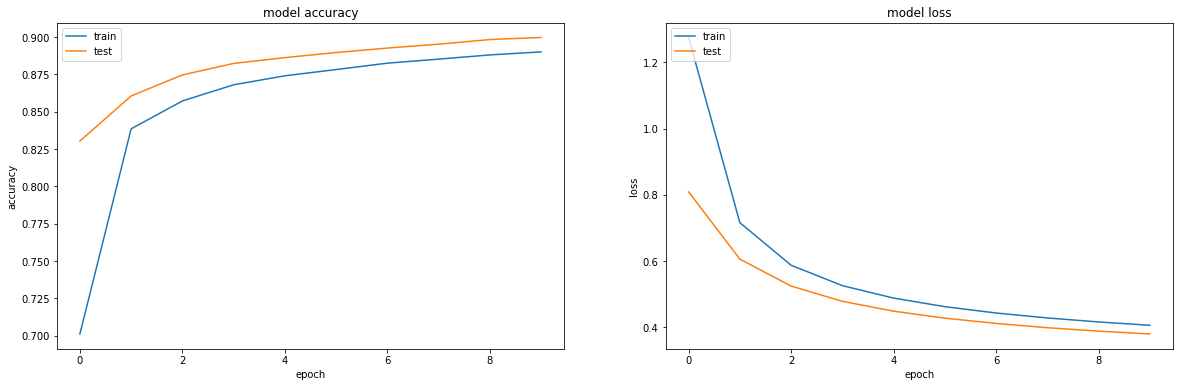

In [5]:
import matplotlib.pyplot as plt

def show_history(history):
  plt.figure(figsize=(20,6))

  # summarize history for accuracy
  plt.subplot(121)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  # summarize history for loss
  plt.subplot(122)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

show_history(history)

###Task 2.1: Training on a smaller data set
Training on the entire MNIST training data set is guaranteed to work (almost) always. Simply because of the large number of images in the training set. This is boring. So let's make our problem a little more challenging by reducing the number of training examples to just 10 from each class. 

In [6]:
import numpy as np

# create smaller training set
digit_indices = np.asarray([np.where(np.argmax(y_train,axis=1) == i)[0][np.random.randint(0,5000,10)] for i in range(num_classes)]).flatten()
x_train_small = x_train[digit_indices,:]
y_train_small = y_train[digit_indices,:]

Test loss: 1.159005045890808
Test accuracy: 0.7516000270843506


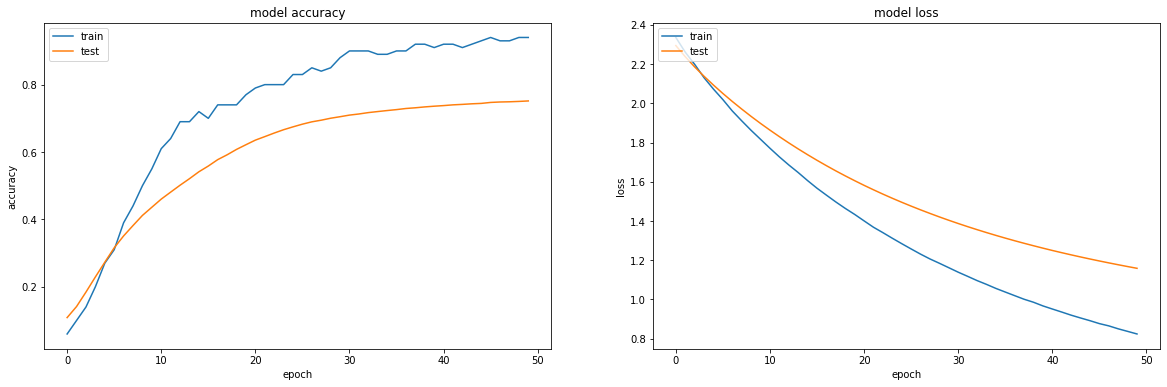

In [7]:
batch_size = 20
epochs = 50 # We need more epochs because we have fewer training samples

# Model (redefine the model in order to reinitialize the weights to random values)
model = Sequential()
model.add(Flatten(input_shape=input_shape))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# Compile the model before training
model.compile(optimizer=keras.optimizers.SGD(),loss='categorical_crossentropy',metrics=['accuracy'])

# Fit model (this will take a little while. Set verbose to 1 if you want to see how training progresses)
history = model.fit(x_train_small, y_train_small,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_test, y_test),
            verbose=0,
            shuffle=True)

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Plot old vs new loss
show_history(history)

###Question 2.2
1. What is the accuracy of our model on the small data set?
2. Try to modify the batch size. Do you notice any differences during training?

###Answer
1. In my case around 75%, which is much lower than when using the entire training set.
2. **Advantages** of using a batch size < number of all samples: Requires less memory since you are training using less samples each iteration; Typically networks learn faster (in a smaller # of epochs) with mini-batches since the weights are updated more often. **Disadvantages**: The smaller the batch the less accurate the estimate of the gradient will be. Processing smaller batches might add up some computational overhead to your training procedure, depending on the hardware.
See more: https://arxiv.org/abs/1804.07612


###Task 2.2: Finding a better learning rate
Your task is to find a better learning rate than the default used above, which is 0.01. You can adjust the learning rate by setting the `lr` argument of keras.optimizer.SGD:

```
keras.optimizers.SGD(lr=0.01)
```

To make the process of finding a better learning rate faster, you may want to initially lower the number of epochs. When you are done searhing for a better learning rate, retrain your model with 200 epochs.


###Solution
I used lr = 0.1. If your compare the curves below, you will see that this makes the model converge faster. Also the accuracy is slightly higher (from 75% to 79%).

Test loss: 0.6812059283256531
Test accuracy: 0.7921000123023987
Loss curves with old learning rate (0.01)


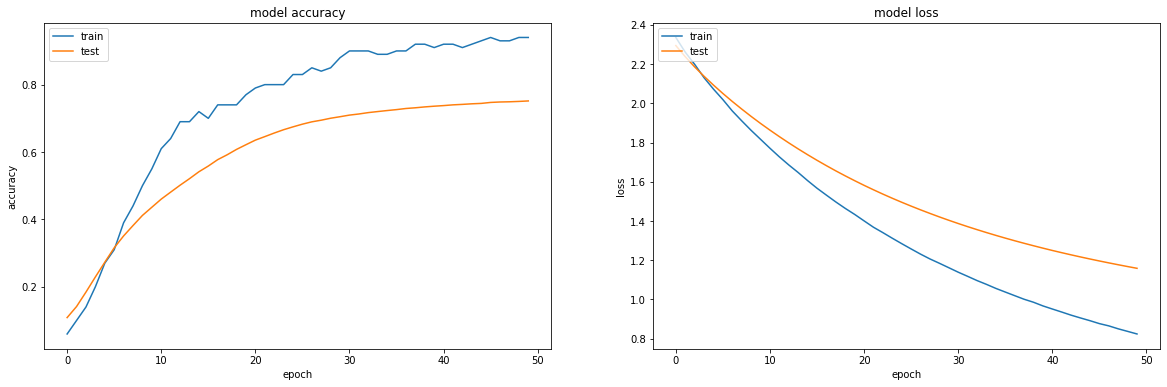

Loss curves with new learning rate (0.1)


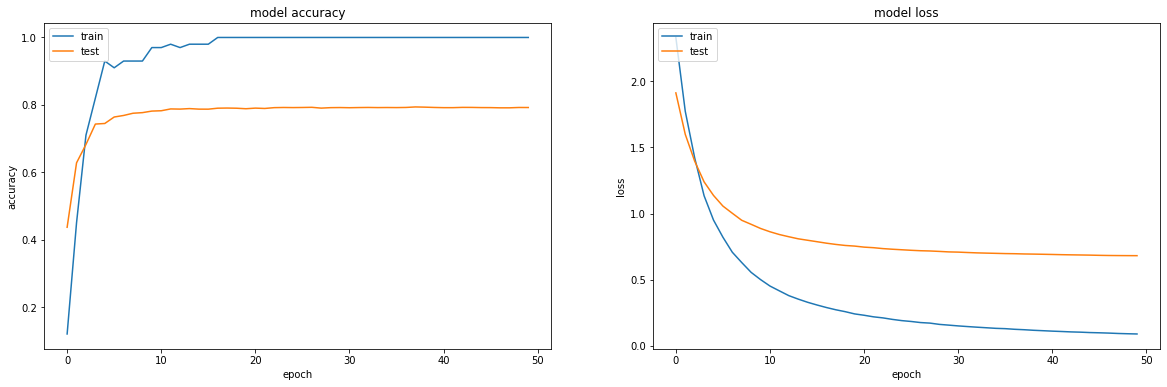

In [8]:
batch_size = 20
epochs = 50

# Model (we redefine it in order to reinitialize the weights to random values)
model = Sequential()
model.add(Flatten(input_shape=input_shape))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# Compile the model before training
model.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='categorical_crossentropy',metrics=['accuracy'])

# Fit model (this will take a little while. Set verbose to 1 if you want to see how training progresses)
history_lr = model.fit(x_train_small, y_train_small,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_test, y_test),
            verbose=0,
            shuffle=True)

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Plot old vs new loss
print("Loss curves with old learning rate (0.01)")
show_history(history)
print("Loss curves with new learning rate (0.1)")
show_history(history_lr)

###Task 2.3: Displaying the learned weights
Figure out a way to extract the learned weight matrix `W` from the model.

Then display them as images (there are 10 classes and one 28x28 weight image per class):

In [ ]:
W = # Your code goes here
W = W.reshape((28,28,10)) # there are 10 classes and one 28x28 weight image per class
plt.figure(figsize=(20,4))
for i in range(10):
  ax = plt.subplot(2,5,i+1)
  plt.imshow(W[:,:,i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.gray()

###Solution

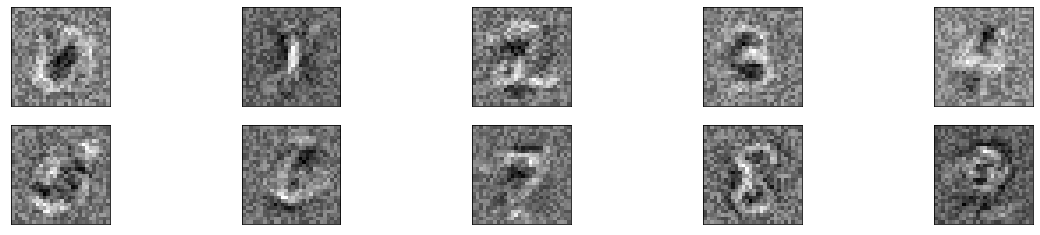

In [10]:
layer = model.layers[1]
W = layer.get_weights()[0]
W = W.reshape((28,28,10)) # there are 10 classes and one 28x28 weight image per class
plt.figure(figsize=(20,4))
for i in range(10):
  ax = plt.subplot(2,5,i+1)
  plt.imshow(W[:,:,i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.gray()

###Task 2.4: Weight decay
With only 10 observations per class in our training data set, it is very likely that our model overfits the training data. This leads to poor generalization (i.e., the model doesn't work that well on unseen data).

One way to avoid overfitting is by means of regularization. The best kind of regularization is "adding more data" (of course). Another possibility is to use weight decay.

So let's try to modify the loss function of the model by adding an L2 regularization term. The regularization term is added using an extra parameter to the Dense layer function.

Compare the performance (accuracy) with the first model with the default learning rate. Don't expect a huge gain in performance (I got around 71%).

Test loss: 2.1365199089050293
Test accuracy: 0.7135999798774719
Loss curves with old learning rate (0.01)


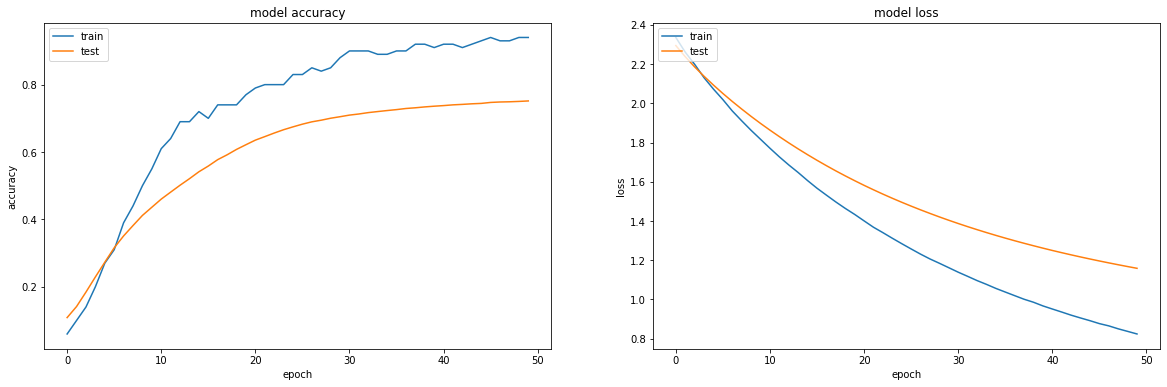

Loss curves with new learning rate (0.1)


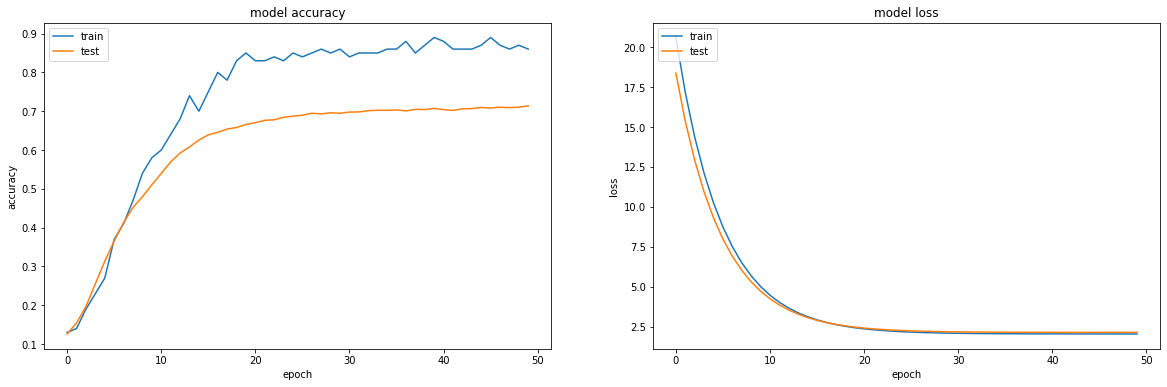

In [11]:
epochs = 50

# lamda is the weight of the L2 penalty term
lamda = 1
L2_regularizer = keras.regularizers.l2(lamda)

# Model
model = Sequential()
model.add(Flatten(input_shape=input_shape))
model.add(Dense(num_classes,
                activation='softmax',
                kernel_regularizer=L2_regularizer))

# Training
model.compile(optimizer=keras.optimizers.SGD(),loss='categorical_crossentropy',metrics=['accuracy'])
history_reg = model.fit(x_train_small, y_train_small,
            batch_size=batch_size,
            epochs=epochs,
            verbose=0,
            validation_data=(x_test, y_test))

# Evaluation
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Plot old vs new loss
print("Loss curves with old learning rate (0.01)")
show_history(history)
print("Loss curves with new learning rate (0.1)")
show_history(history_reg)

**Now comes the interesting part:** Try once more to display the weights - this time of the regularized model.

In [ ]:
#W = # Your code goes here
W = W.reshape((28,28,10))
plt.figure(figsize=(20,4))
for i in range(10):
  ax = plt.subplot(2,5,i+1)
  plt.imshow(W[:,:,i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.gray()

###Questions 2.2
1. How do the weights of the regularized model differ from the weights of the non-regularized model?
2. Can you explain why?

###Solution
1. They are far less noisy
2. Adding the L2 penalty makes the model prefer small weights, eventually forcing non-used weights towards zero.

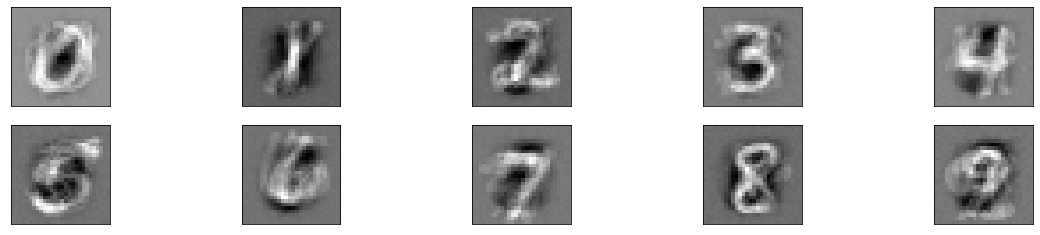

In [12]:
layer = model.layers[1]
W = layer.get_weights()[0]
W = W.reshape((28,28,10)) # there are 10 classes and one 28x28 weight image per class
plt.figure(figsize=(20,4))
for i in range(10):
  ax = plt.subplot(2,5,i+1)
  plt.imshow(W[:,:,i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.gray()

###Functional API instead of Sequential API
The models above have been specified using Keras' [Sequential API](https://keras.io/getting-started/sequential-model-guide/). Keras also allows you to specify models a [Functional API](https://keras.io/getting-started/functional-api-guide/). The Keras functional API is the way to go for defining complex models, such as multi-output models, directed acyclic graphs, or models with shared layers.

Here is how to set up the logistic regression model using the functional API:

In [13]:
from keras.layers import Input
from keras.models import Model

# This returns a tensor
inputs = Input(shape=input_shape)

# A layer instance is callable on a tensor, and returns a tensor
x = Flatten()(inputs)
x = Dense(num_classes)(x)
predictions = Activation('softmax')(x)

# This creates a model that includes the Input layer and the prediction layer
model = Model(inputs=inputs, outputs=predictions)

# Training
model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(x_train, y_train,
          batch_size=50,
          epochs=5,
          verbose=1,
          validation_data=(x_test, y_test))

# Evaluation
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/5
1200/1200 [==============================] - 3s 3ms/step - loss: 0.9228 - accuracy: 0.7775 - val_loss: 0.5584 - val_accuracy: 0.8644
Epoch 2/5
1200/1200 [==============================] - 3s 3ms/step - loss: 0.5172 - accuracy: 0.8681 - val_loss: 0.4495 - val_accuracy: 0.8841
Epoch 3/5
1200/1200 [==============================] - 3s 3ms/step - loss: 0.4469 - accuracy: 0.8824 - val_loss: 0.4048 - val_accuracy: 0.8924
Epoch 4/5
1200/1200 [==============================] - 3s 3ms/step - loss: 0.4123 - accuracy: 0.8892 - val_loss: 0.3795 - val_accuracy: 0.8982
Epoch 5/5
1200/1200 [==============================] - 3s 3ms/step - loss: 0.3908 - accuracy: 0.8942 - val_loss: 0.3633 - val_accuracy: 0.9009
Test loss: 0.3632756173610687
Test accuracy: 0.9009000062942505


##Task 3: Our first CNN
Here we will build and train our own CNN.

Here is a simple example:

In [14]:
from keras.layers import Dropout
from keras.layers import Conv2D, MaxPooling2D

inputs = Input(shape=(28, 28, 1))

# Encoder (convolutional base)
x = Conv2D(8, kernel_size=(3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(16, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
encoded = Flatten()(x)

# Decoder (2 fully connected layers)
x = Dense(64, activation='relu')(encoded)
x = Dropout(0.5)(x)
predictions = Dense(num_classes,activation='softmax')(x)

# This creates a callable model that includes the Input layer and the prediction layer
model = Model(inputs=inputs, outputs=predictions)

model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 32)          4640      
_________________________________________________________________
flatten_5 (Flatten)          (None, 288)              

###Questions 3.1
1. How many layers does this CNN have?
2. What does the MaxPooling2D layer do?
3. What does the Dropout layer do?
4. What is the shape of the input of the last convolutiona layer (i.e., just before the flatten layer)

###Answers
1. It has 10 layers of which 9 are actually computing something (Flatten layer just vectorizes). In comparison, the logistic regression model had only 1 layer that computed something. More layers is in general better, which is why this CNN achieves higher accuracy.
2. MaxPooling2D is a way of downsampling the input (feature maps). It serves to throw away information that we assume we won't be needing anymore. For each 2x2 cell, max pooling simply transfers the maximum value (= the most important activation). Max pooling also helps us achieve some degree of translation invariance.
3. Dropout consists in randomly setting a fraction rate of input units to 0 at each update during training time, which helps prevent overfitting. You can think of it like having a whole ensemble of models. In each update, we randomly pick one of those models and update it. After training, when we perform prediction, dropout is disabled. In that case our output prediction is effectively a kind of voting among many models, which just generalizes better. You can compare to K-NN: We tend to get better predictions if we set K > 1 than K = 1.
4. It is 3x3x32 (= 288 when multiplied together, so that is the shape of the output of the Flatten layer).

For the record, the same model can also be defined using the sequential API:


```
from keras.layers import Dropout
from keras.layers import Conv2D ![alt text](https://), MaxPooling2D

input_img = Input(shape=(28, 28, 1))
model = Sequential()
model.add(Conv2D(8,
                 kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16,
                 kernel_size=(3, 3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32,
                 kernel_size=(3, 3),
                 activation='relu'))
model.add(Flatten())
model.add(Dense(64,
                activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()
```



###Training
Let's train our model

In [15]:
model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=100,
                    epochs=5,
                    verbose=1,
                    validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/5
600/600 [==============================] - 4s 6ms/step - loss: 1.6333 - accuracy: 0.4461 - val_loss: 0.4990 - val_accuracy: 0.8715
Epoch 2/5
600/600 [==============================] - 4s 6ms/step - loss: 0.6103 - accuracy: 0.8067 - val_loss: 0.2928 - val_accuracy: 0.9149
Epoch 3/5
600/600 [==============================] - 4s 6ms/step - loss: 0.4404 - accuracy: 0.8640 - val_loss: 0.2018 - val_accuracy: 0.9376
Epoch 4/5
600/600 [==============================] - 4s 6ms/step - loss: 0.3550 - accuracy: 0.8911 - val_loss: 0.1713 - val_accuracy: 0.9472
Epoch 5/5
600/600 [==============================] - 4s 6ms/step - loss: 0.3070 - accuracy: 0.9068 - val_loss: 0.1492 - val_accuracy: 0.9555
Test loss: 0.14916063845157623
Test accuracy: 0.9555000066757202


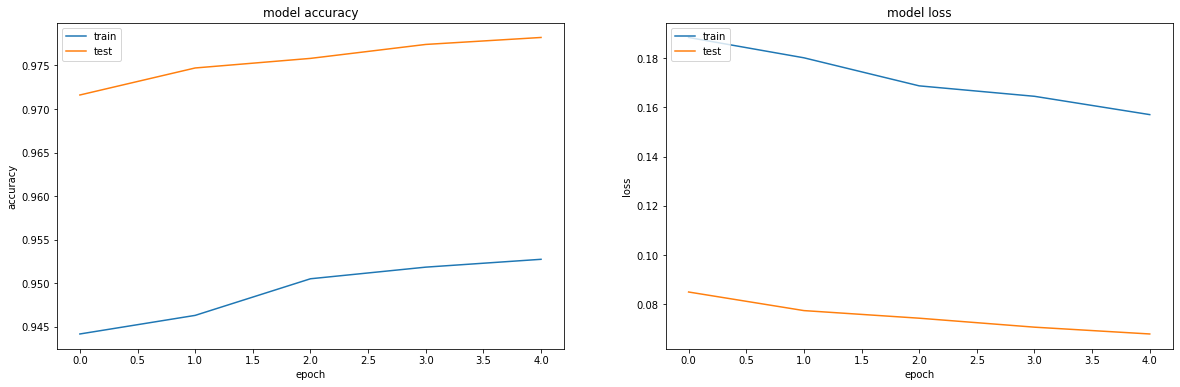

In [ ]:
show_history(history)

###Task 3.1
In the above model the input shape to the Flatten layer  is 3x3x32, which is then flattened to a 288-dimensional vector (this is the variable named `encoded`)

Your task is to modify the network such that variable `encoded` has dimensionality 2 instead of 288.

Hint: You could insert an extra layer before the Flatten layer that reduces the 3x3x32 input tensor to a 1x1x2 tensor. There are several solutions.

In [ ]:
from keras.layers import Dropout
from keras.layers import Conv2D, MaxPooling2D

inputs = Input(shape=(28, 28, 1))

# Encoder (convolutional base)
x = Conv2D(8, kernel_size=(3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(16, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
x = # Your code goes here
encoded = Flatten()(x)

# Decoder (2 fully connected layers)
x = Dense(64, activation='relu')(encoded)
x = Dropout(0.5)(x)
predictions = Dense(num_classes,activation='softmax')(x)

# This creates a callable model that includes the Input layer and the prediction layer
model = Model(inputs=inputs, outputs=predictions)

model.summary()

###Solution

In [16]:
from keras.layers import Dropout
from keras.layers import Conv2D, MaxPooling2D

inputs = Input(shape=(28, 28, 1))

# Encoder (convolutional base)
x = Conv2D(8, kernel_size=(3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(16, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
x = Conv2D(2, kernel_size=(3, 3), activation='tanh')(x) # I chose tanh because it will make the plot below look nice. You could use relu, sigmoid or None
encoded = Flatten()(x)

# Decoder (2 fully connected layers)
x = Dense(64, activation='relu')(encoded)
x = Dropout(0.5)(x)
predictions = Dense(num_classes,activation='softmax')(x)

# This creates a callable model that includes the Input layer and the prediction layer
model = Model(inputs=inputs, outputs=predictions)

model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 8)         80        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 16)        1168      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 32)          4640      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1, 1, 2)          

###Training
Train the model.

In [17]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=100,
          epochs=10,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
600/600 [==============================] - 4s 7ms/step - loss: 1.7326 - accuracy: 0.3342 - val_loss: 1.1362 - val_accuracy: 0.5611
Epoch 2/10
600/600 [==============================] - 4s 7ms/step - loss: 0.9511 - accuracy: 0.6665 - val_loss: 0.5358 - val_accuracy: 0.8881
Epoch 3/10
600/600 [==============================] - 4s 7ms/step - loss: 0.5604 - accuracy: 0.8498 - val_loss: 0.3302 - val_accuracy: 0.9297
Epoch 4/10
600/600 [==============================] - 4s 7ms/step - loss: 0.3963 - accuracy: 0.9034 - val_loss: 0.2287 - val_accuracy: 0.9516
Epoch 5/10
600/600 [==============================] - 4s 7ms/step - loss: 0.3250 - accuracy: 0.9256 - val_loss: 0.2489 - val_accuracy: 0.9450
Epoch 6/10
600/600 [==============================] - 4s 7ms/step - loss: 0.2852 - accuracy: 0.9341 - val_loss: 0.1907 - val_accuracy: 0.9578
Epoch 7/10
600/600 [==============================] - 4s 7ms/step - loss: 0.2538 - accuracy: 0.9442 - val_loss: 0.1517 - val_accuracy: 0.9668
Epoch 

###Task 3.2
Run all test examples through your model and for each example extract the 2-dimensional vector output of the Flatten layer (variable named `encoded`). To make predictions on a batch, you can do like this: ``out = model_encoded.predict(batch)``.

Then plot those vectors in a 2D plot, where each class gets its own color.

You might find this code useful:

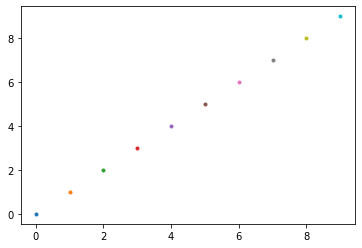

In [18]:
model_encoded = Model(inputs=model.input, outputs=encoded)

# Plot 10 dots with 10 different colors
for i in range(10):
  plt.plot(i,i,'.C'+str(i))

###Solution

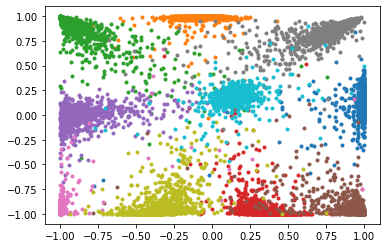

In [19]:
import numpy as np

# Get 2D encoding of all test examples (in batches of 100 images)
x_test_2d = np.zeros((x_test.shape[0],2))
num_batch = int(x_test.shape[0] / 100)
for i in range(num_batch):
  batch = x_test[i*100:(i+1)*100,:,:,:]
  out = model_encoded.predict(batch)
  x_test_2d[i*100:(i+1)*100,:] = out

# Get class index for each test example
y_test_category = np.argmax(y_test,axis=1)

# Plot
for i in range(10):
  idx = np.where(y_test_category == i)
  plt.plot(x_test_2d[idx,0],x_test_2d[idx,1],'.C'+str(i))

###Comment
The point of this little exercise is to show you that you can use CNN encoders to compress images down to just 2 dimensions. This is a powerful concept for visualizing high-dimensional data. In this example, the 2D representation actually separates the 10 classes quite nicely.

##Task 4: Convolutional Autoencoder
Autoencoders are special types of neural networks that map the input X to the same output (namely X). So the autoencoder (AE) is an identity function:

```
X = AE(X)
```

So what's the point? The point is that the autoencoder compresses the image down to a low-dimensional representation, which can be decoded again to reconstruct the original input image. This has many useful applications, such as data compression and representation learning. Only the important information is stored in the low-dimensional representation.

The autoencoder consists of a trained encoder (E) and a trained decoder (D):

```
X = AE(X) = D(E(X))
```

It is typically (but not always) the encoding E(X) that we are interested in.

Note that the autoecoder does not need the class labels to train. So it is an *unsupervised* machine learning technique.

Here is an example of a convolutional autoencoder:

In [20]:
from keras.layers import UpSampling2D

inputs = Input(shape=(28, 28, 1))

# Encoder (convolutional base)
x = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
print(("shape of encoded", K.int_shape(encoded)))

# Decoder (upsamling)
x = Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same')(x) 
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, kernel_size=(5, 5), padding='valid')(x)
print(("shape of decoded", K.int_shape(decoded)))

autoencoder = Model(inputs, decoded)
autoencoder.summary()

('shape of encoded', (None, 4, 4, 8))
('shape of decoded', (None, 28, 28, 1))
Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 8)           584       
__________________________________________

###Questions 4.1
1. What is the shape of the encoded image?
2. Why are we not flattening (i.e., vectorizing) the encoded image like we did before?
3. What does UpSampling2D do?
4. Why do you think upsampling is followed by a convolution?
5. What is the difference between using `padding='same'` and `padding='valid'`?

###Answers
1. 4x4x8
2. Before we need to flatten/vectorize because of the Dense layer, which contains a matrix-vector multiplication. Now, we are performing 2D convolution instead, which operates on images.
3. In this case it just doubles the size of the input using nearest neighbour interpolation
4. Without the convolutions, successive upsamplings would just "replicate" the pixels of the 4x4x8 encoding, so the effective resolution of the output image would be 4x4 pixels. By inserting convolutions between upsamlings, we eliminate the replicates and get a less jaggy output image.
5. For 'valid' the convolution kernel stays inside the input image, resulting in an output image that is smaller. For 'same' the input image is zero-padded before convolution, such that input and output have the same shape.


###Training
Let's train the autoencoder:

In [21]:
autoencoder.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), loss='mse')
autoencoder.fit(x_train, x_train, epochs=10, batch_size=100,
               shuffle=True, validation_data=(x_test, x_test), verbose=1)

Epoch 1/10
600/600 [==============================] - 5s 8ms/step - loss: 0.0693 - val_loss: 0.0506
Epoch 2/10
600/600 [==============================] - 5s 8ms/step - loss: 0.0460 - val_loss: 0.0427
Epoch 3/10
600/600 [==============================] - 5s 8ms/step - loss: 0.0406 - val_loss: 0.0384
Epoch 4/10
600/600 [==============================] - 5s 8ms/step - loss: 0.0370 - val_loss: 0.0352
Epoch 5/10
600/600 [==============================] - 5s 8ms/step - loss: 0.0342 - val_loss: 0.0326
Epoch 6/10
600/600 [==============================] - 5s 8ms/step - loss: 0.0320 - val_loss: 0.0307
Epoch 7/10
600/600 [==============================] - 5s 8ms/step - loss: 0.0303 - val_loss: 0.0292
Epoch 8/10
600/600 [==============================] - 5s 8ms/step - loss: 0.0289 - val_loss: 0.0281
Epoch 9/10
600/600 [==============================] - 5s 8ms/step - loss: 0.0279 - val_loss: 0.0271
Epoch 10/10
600/600 [==============================] - 5s 8ms/step - loss: 0.0270 - val_loss: 0.0263

In [22]:
# utility function for showing images
def show_imgs(x_test, n=10):
    sz = x_test.shape[1]
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i+1)
        plt.imshow(x_test[i].reshape(sz,sz))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

input (upper row)


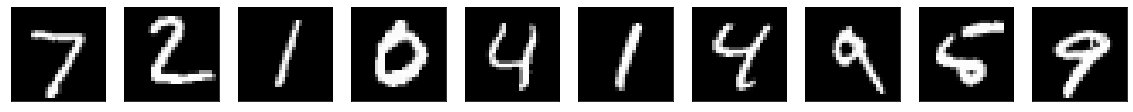

decoded (bottom row)


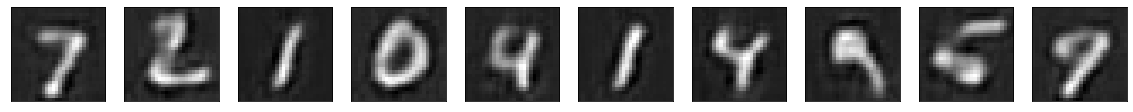

In [23]:
decoded_imgs = autoencoder.predict(x_test)
print("input (upper row)")
show_imgs(x_test)
print("decoded (bottom row)")
show_imgs(decoded_imgs)

###Improving the autoencoder
This is good, but not great. Let's use cross entropy loss instead. This requires that the decoding is a probability, hence the sigmoid below:

In [24]:
decoded_sigmoid = Activation('sigmoid')(decoded) # decoded is the output of the first autoencoder
autoencoder2 = Model(inputs, decoded_sigmoid)
autoencoder2.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), loss='binary_crossentropy')
autoencoder2.fit(x_train, x_train, epochs=10, batch_size=100,
               shuffle=True, validation_data=(x_test, x_test), verbose=1)

Epoch 1/10
600/600 [==============================] - 5s 8ms/step - loss: 0.1492 - val_loss: 0.1289
Epoch 2/10
600/600 [==============================] - 5s 8ms/step - loss: 0.1273 - val_loss: 0.1251
Epoch 3/10
600/600 [==============================] - 5s 8ms/step - loss: 0.1234 - val_loss: 0.1202
Epoch 4/10
600/600 [==============================] - 5s 8ms/step - loss: 0.1207 - val_loss: 0.1177
Epoch 5/10
600/600 [==============================] - 5s 8ms/step - loss: 0.1185 - val_loss: 0.1191
Epoch 6/10
600/600 [==============================] - 5s 8ms/step - loss: 0.1169 - val_loss: 0.1145
Epoch 7/10
600/600 [==============================] - 5s 8ms/step - loss: 0.1156 - val_loss: 0.1133
Epoch 8/10
600/600 [==============================] - 5s 8ms/step - loss: 0.1143 - val_loss: 0.1192
Epoch 9/10
600/600 [==============================] - 5s 8ms/step - loss: 0.1132 - val_loss: 0.1139
Epoch 10/10
600/600 [==============================] - 5s 8ms/step - loss: 0.1123 - val_loss: 0.1100

input (upper row)


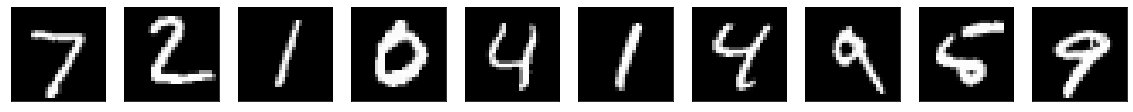

decoded (bottom row)


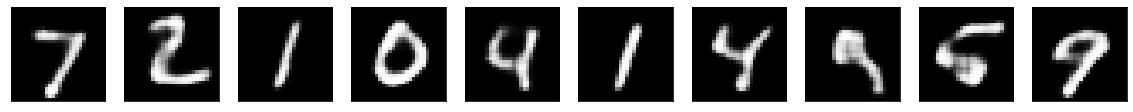

In [25]:
decoded_imgs = autoencoder2.predict(x_test)
print("input (upper row)")
show_imgs(x_test)
print("decoded (bottom row)")
show_imgs(decoded_imgs)

###Questions 4.2
1. What is the difference between 'mse' loss and 'binary_crossentropy' loss?
2. Can you explain why 'binary_crossentropy' works better?

###Answers
1. The 'mse' (mean squared error) loss is just a summation over the squared errors between y_pred and y_true [`mse = sum((y_pred-y_true)^2`)], whereas the binary cross entropy is [`H = sum(y_true*log(y_pred) + (1-y_true)*log(1-y_pred))`].
2. Because of the log, errors get punished harder with binary cross entropy, which drives the model to a good solution faster compared to when using mse loss.

##Task 5: Denoising Autoencoder
Autoencoders can get really advanced, like [Variational Autoencoders](https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf). A slightly less complicated, yet powerful autoecoder variant is the [Denoising Autoencoder](https://www.cs.toronto.edu/~larocheh/publications/icml-2008-denoising-autoencoders.pdf).

As stated above autoencoders have many useful applications. One of these is *noise reduction*. The underlying idea is very simple: Add random noise to the input X, and teach the autoencoder to remove the noise. That is, the autoencoder should learn the mapping:

```
X = AE(X + noise)
```

###Task 5.1
Create two new data sets based on x_train and x_test, where you have added noise such that

```
x_train_noisy = x_train + noise
x_test_noisy = x_test + noise
```

You may want to look at numpy functions like np.random.normal and np.clip

Retrain autoencoder2 on the noisy images (input = x_train_noisy and output = x_train).

High much noise can you add before the thing breaks down?

In [ ]:
#Your code goes here
#x_train_noisy = ???
#x_test_noisy = ???

###Solution
Inspiration: https://gist.github.com/naotokui/b9fb93b8dba534b55a140e8c88ce07f5

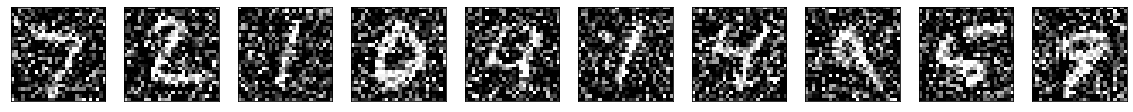

In [26]:
# Add random noise before training!
noise_factor = 0.5 
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
x_train_noisy = np.clip(x_train_noisy, 0., 1.) 
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

show_imgs(x_test_noisy)

In [27]:
# it takes more epochs to converge
autoencoder2.fit(x_train_noisy, x_train, epochs=10, batch_size=100,
                shuffle=True, validation_data=(x_test_noisy, x_test))

Epoch 1/10
600/600 [==============================] - 5s 8ms/step - loss: 0.1511 - val_loss: 0.1435
Epoch 2/10
600/600 [==============================] - 5s 8ms/step - loss: 0.1440 - val_loss: 0.1422
Epoch 3/10
600/600 [==============================] - 5s 8ms/step - loss: 0.1424 - val_loss: 0.1400
Epoch 4/10
600/600 [==============================] - 5s 8ms/step - loss: 0.1408 - val_loss: 0.1386
Epoch 5/10
600/600 [==============================] - 5s 8ms/step - loss: 0.1397 - val_loss: 0.1375
Epoch 6/10
600/600 [==============================] - 5s 8ms/step - loss: 0.1386 - val_loss: 0.1367
Epoch 7/10
600/600 [==============================] - 5s 8ms/step - loss: 0.1377 - val_loss: 0.1359
Epoch 8/10
600/600 [==============================] - 5s 8ms/step - loss: 0.1369 - val_loss: 0.1351
Epoch 9/10
600/600 [==============================] - 5s 8ms/step - loss: 0.1363 - val_loss: 0.1343
Epoch 10/10
600/600 [==============================] - 5s 8ms/step - loss: 0.1356 - val_loss: 0.1339

denoising
input (upper row)


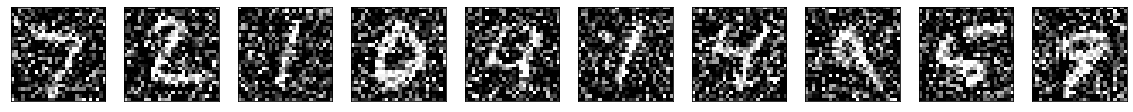

decoded (bottom row)


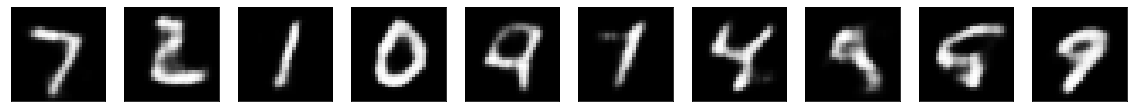


of course, it works with original noise-less images
input (upper row)


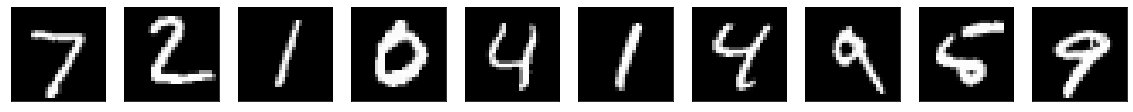

decoded (bottom row)


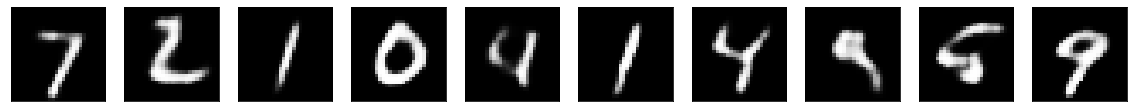

In [28]:
# denoising
print("denoising")
decoded_imgs = autoencoder2.predict(x_test_noisy)
print("input (upper row)")
show_imgs(x_test_noisy)
print("decoded (bottom row)")
show_imgs(decoded_imgs)

# what if we feed the original noise-free test images?
decoded_imgs = autoencoder2.predict(x_test)
print("\nof course, it works with original noise-less images")
print("input (upper row)")
show_imgs(x_test)
print("decoded (bottom row)")
show_imgs(decoded_imgs)

##Task 6: Super resolution
The convolutional autoencoder is a network that maps an image to another image. There are other types of these *image-to-image networks*.

One example is a super resolution network. This is pretty much an autoencoder, except that the input image has lower spatial resolution than the output image. Super resolution networks learn to increase the spatial of the input image.

Your task is to modify the autoencoder such that it takes an 14x14x1 image as input and transforms it to a 28x28x1 image. Specifically, the training and test inputs should be



Input low resolution images


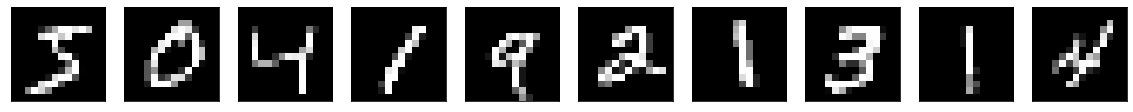

Output high resolution images (target)


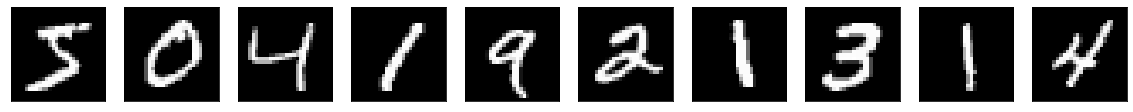

In [29]:
# Low resolution images (pick every other pixel)
x_train_small = x_train[:,::2,::2,:] 
x_test_small = x_test[:,::2,::2,:]

# Show example
print("Input low resolution images")
show_imgs(x_train_small)
print("Output high resolution images (target)")
show_imgs(x_train)

###Solution

In [30]:
inputs = Input(shape=(14, 14, 1))

# Encoder (convolutional base)
x = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
print(("shape of encoded", K.int_shape(encoded)))

# Decoder (upsamling)
x = Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same')(x) 
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, kernel_size=(5, 5), activation='sigmoid', padding='valid')(x)
print(("shape of decoded", K.int_shape(decoded)))

superres = Model(inputs, decoded)
superres.summary()

('shape of encoded', (None, 4, 4, 8))
('shape of decoded', (None, 28, 28, 1))
Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 14, 14, 1)]       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 16)        160       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 7, 7, 8)           1160      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 8)           0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 4, 4, 8)           584       
_________________________________________

In [31]:
superres.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), loss='binary_crossentropy')

# it takes more epochs to converge
superres.fit(x_train_small, x_train, epochs=10, batch_size=100,
             shuffle=True, validation_data=(x_test_small, x_test))

Epoch 1/10
600/600 [==============================] - 4s 7ms/step - loss: 0.2356 - val_loss: 0.1781
Epoch 2/10
600/600 [==============================] - 4s 6ms/step - loss: 0.1687 - val_loss: 0.1588
Epoch 3/10
600/600 [==============================] - 4s 6ms/step - loss: 0.1541 - val_loss: 0.1478
Epoch 4/10
600/600 [==============================] - 4s 6ms/step - loss: 0.1456 - val_loss: 0.1435
Epoch 5/10
600/600 [==============================] - 4s 6ms/step - loss: 0.1400 - val_loss: 0.1362
Epoch 6/10
600/600 [==============================] - 4s 6ms/step - loss: 0.1361 - val_loss: 0.1334
Epoch 7/10
600/600 [==============================] - 4s 6ms/step - loss: 0.1330 - val_loss: 0.1305
Epoch 8/10
600/600 [==============================] - 4s 6ms/step - loss: 0.1305 - val_loss: 0.1277
Epoch 9/10
600/600 [==============================] - 4s 6ms/step - loss: 0.1283 - val_loss: 0.1258
Epoch 10/10
600/600 [==============================] - 4s 6ms/step - loss: 0.1264 - val_loss: 0.1240

super resolution
input (upper row)


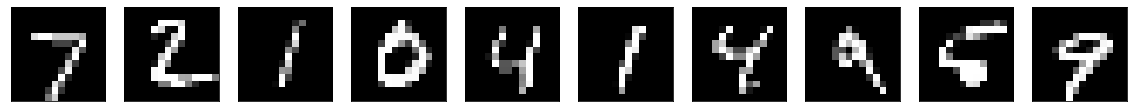

decoded (bottom row)


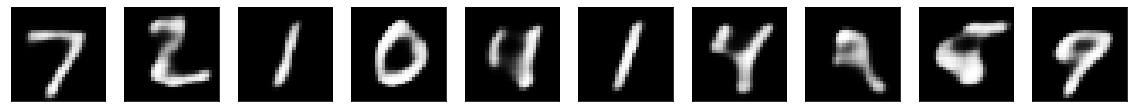

ground truth


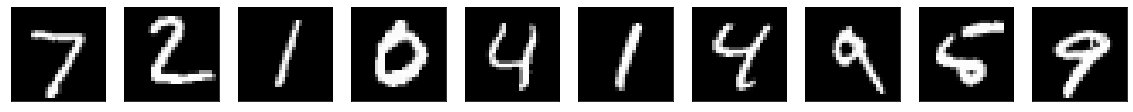

In [32]:
# super resolution
print("super resolution")
decoded_imgs = superres.predict(x_test_small)
print("input (upper row)")
show_imgs(x_test_small)
print("decoded (bottom row)")
show_imgs(decoded_imgs)
print("ground truth")
show_imgs(x_test)

##Task 7: Image regression
Recall that regression problems are when the output of the model is one or more scalar values, rather than class labels. Both the autoencoder and super resolution network are examples of regression models. Another example of image regression is [facial landmark prediction](https://medium.com/@rishiswethan.c.r/emotion-detection-using-facial-landmarks-and-deep-learning-b7f54fe551bf), which can be used for emotion recognition.

In this task we will estimate the rotation angle of rotated MNIST images (but it could just as well have been estimating pixel coordinates of facial landmarks).

As a first step, we need an image generator that generates batches of randomly rotated images, along with the target rotation angles that the model should learn to predict. This code was modified from https://d4nst.github.io/2017/01/12/image-orientation/



In [33]:
from keras.preprocessing.image import Iterator
from keras.utils.np_utils import to_categorical
import cv2

class RotNetDataGenerator(Iterator):

    def __init__(self, input, batch_size=64,
                 preprocess_func=None, shuffle=False):

        self.images = input
        self.batch_size = batch_size
        self.input_shape = self.images.shape[1:]
        self.preprocess_func = preprocess_func
        self.shuffle = shuffle

        # add dimension if the images are greyscale
        if len(self.input_shape) == 2:
            self.input_shape = self.input_shape + (1,)
        N = self.images.shape[0]

        super(RotNetDataGenerator, self).__init__(N, batch_size, shuffle, None)
        
    def _get_batches_of_transformed_samples(self, index_array):
        # create array to hold the images
        batch_x = np.zeros((len(index_array),) + self.input_shape, dtype='float32')
        # create array to hold the labels
        batch_y = np.zeros(len(index_array), dtype='float32')

        # iterate through the current batch
        for i, j in enumerate(index_array):
          
            image = self.images[j].squeeze()

            # get a random angle
            rotation_angle = np.random.randint(-45,45)

            # rotate the image
            rows,cols = image.shape
            M = cv2.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),rotation_angle,1)
            rotated_image = cv2.warpAffine(image,M,(cols,rows))

            # add dimension to account for the channels if the image is greyscale
            if rotated_image.ndim == 2:
                rotated_image = np.expand_dims(rotated_image, axis=2)

            # store the image and label in their corresponding batches
            batch_x[i] = rotated_image
            batch_y[i] = rotation_angle

        # preprocess input images
        if self.preprocess_func:
            batch_x = self.preprocess_func(batch_x)

        return batch_x, batch_y

    def next(self):
        with self.lock:
            # get input data index and size of the current batch
            index_array = next(self.index_generator)
        # create array to hold the images
        return self._get_batches_of_transformed_samples(index_array)

###Test the generator

Images (before rotation)


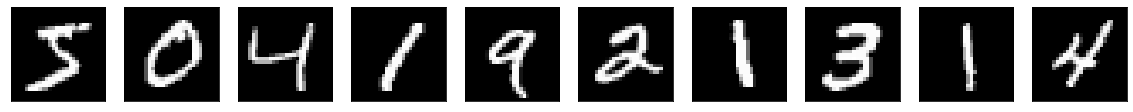

Images after random rotation


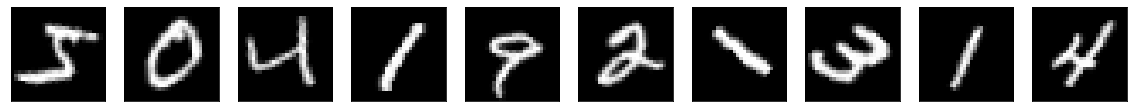

In [34]:
# Instantiate
datagen = RotNetDataGenerator(
        x_train,
        batch_size=32,
        preprocess_func=None,
        shuffle=False
    )

# Generate batch
rotated_images, angles = datagen.next()

# Display
print("Images (before rotation)")
show_imgs(x_train)
print("Images after random rotation")
show_imgs(rotated_images)

###Task 7.1
Make a small CNN that takes as input an 28x28x1 image and outputs a single scalar value (the rotation angle).

The last layer of your network should be

```
angle = Dense(1)(x)
```

This is a dense layer without any activation function, hence the output of this layer is simply `angle = W*x + b`.

In [ ]:
inputs = Input(shape=(28, 28, 1))

# Encoder (convolutional base)
# Your codes goes here

# Decoder (predict angle)
x = # Your code goes here
angle = Dense(1)(x)

angle_estimator = Model(input=inputs, output=angle)

###Solution

In [35]:
inputs = Input(shape=(28, 28, 1))

# Encoder (convolutional base)
x = Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2, 2), padding='valid')(x)
x = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='valid')(x)
x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='valid')(x)

# Decoder (predic angle)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
angle = Dense(1)(x)

angle_estimator = Model(inputs, angle)

angle_estimator.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 28, 28, 8)         80        
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 14, 14, 16)        1168      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 7, 7, 32)          4640      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 3, 3, 32)        

###Training

In [36]:
angle_estimator.compile(optimizer='rmsprop',loss='mse')

# training loop
angle_estimator.fit_generator(
    RotNetDataGenerator(
        x_train,
        batch_size=100,
        preprocess_func=None,
        shuffle=True
    ),
    epochs=50,
    validation_data=RotNetDataGenerator(
        x_test,
        batch_size=100,
        preprocess_func=None))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
600/600 [==============================] - 6s 10ms/step - loss: 298.6784 - val_loss: 180.8741
Epoch 2/50
600/600 [==============================] - 6s 10ms/step - loss: 205.6031 - val_loss: 192.4565
Epoch 3/50
600/600 [==============================] - 6s 10ms/step - loss: 180.0286 - val_loss: 132.7785
Epoch 4/50
600/600 [==============================] - 6s 10ms/step - loss: 166.9205 - val_loss: 130.7988
Epoch 5/50
600/600 [==============================] - 6s 10ms/step - loss: 155.4926 - val_loss: 128.0365
Epoch 6/50
600/600 [==============================] - 6s 10ms/step - loss: 148.4568 - val_loss: 119.8539
Epoch 7/50
600/600 [==============================] - 6s 10ms/step - loss: 141.4180 - val_loss: 104.8030
Epoch 8/50
600/600 [==============================] - 6s 10ms/step - loss: 138.8388 - val_loss: 102.6451
Epoch 9/50
600/600 [==============================] - 6s 10ms/step - loss: 133.3593 

###Model evaluation

Test images before rotation


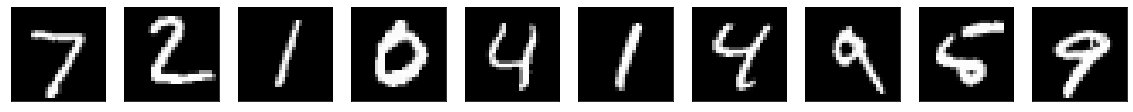

Test images after rotation


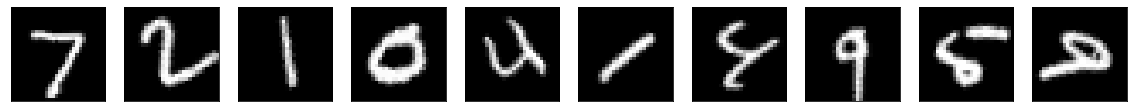

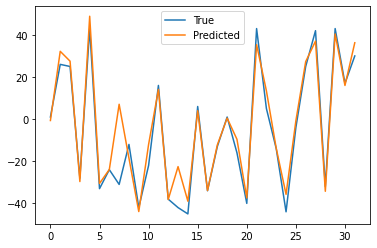

In [37]:
# Set up generator
datagen = RotNetDataGenerator(
        x_test,
        batch_size=32,
        preprocess_func=None,
        shuffle=False
    )

# Generate test images
rotated_images, angles = datagen.next()
print("Test images before rotation")
show_imgs(x_test)
print("Test images after rotation")
show_imgs(rotated_images)

# Predict angles
angles_pred = angle_estimator.predict(rotated_images)

# Plot angles
plt.plot(angles)
plt.plot(angles_pred)
plt.legend(['True','Predicted']);

**HELP**: The predicted angles should match the true angles reasonably well. If your model fails to predict the angles, it could be because the model is underfitting. This indicates that the capacity of the model is too low. To increase capacity, add more connections in dense layers and/or more output maps in convolutional layers (I will explain this in the class).

###De-rotate images
Now that we have estimated the rotation angles, let's de-rotate the images back to their original alignment.

Images before rotation (ground truth)


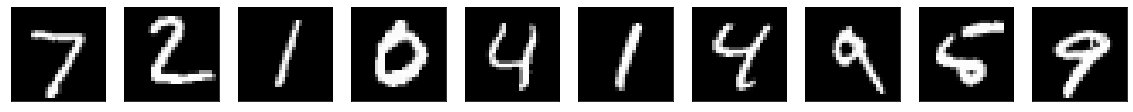

Images after rotation (to be de-rotated)


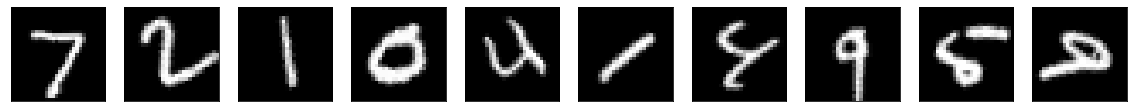

De-rotated images (should match ground truth)


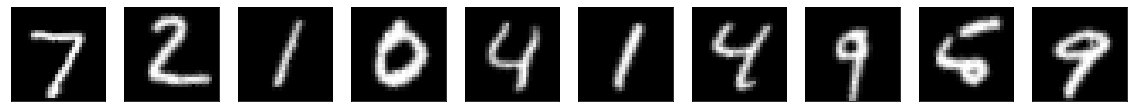

In [38]:
de_rotated_images = np.zeros(rotated_images.shape)

for i in range(rotated_images.shape[0]):
  image = rotated_images[i,:,:,:].squeeze()

  # get predicted angle
  rotation_angle = -angles_pred[i]

  # rotate the image
  rows,cols = image.shape
  M = cv2.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),rotation_angle,1)
  de_rotated_image = cv2.warpAffine(image,M,(cols,rows))

  de_rotated_images[i,:,:,0] = de_rotated_image

print('Images before rotation (ground truth)')
show_imgs(x_test)
print('Images after rotation (to be de-rotated)')
show_imgs(rotated_images)
print('De-rotated images (should match ground truth)')
show_imgs(de_rotated_images)

##Task 8: Object detection
**Motivation:** Classification CNNs assign one label to each input image. This is problematic if the image contains multiple objects. 

Object detection is about detecting and classifying multiple objects in images. Object detection networks output the corner coordinates of the bounding box of each detect object, along with a class label.

There are many ways to implement object detection with CNNs. You may want to take a look at this 3-part tutorial:
- https://towardsdatascience.com/beginners-guide-to-object-detection-algorithms-6620fb31c375
- https://www.analyticsvidhya.com/blog/2018/11/implementation-faster-r-cnn-python-object-detection/?utm_source=blog&utm_medium=a-step-by-step-introduction-to-the-basic-object-detection-algorithms-part-1
- https://www.analyticsvidhya.com/blog/2018/12/practical-guide-object-detection-yolo-framewor-python/?utm_source=blog&utm_medium=implementation-faster-r-cnn-python-object-detection

The basic idea of our simple object detector below is as follows:

- The output image is divided into a 2-by-2 grid
- Each grid cell can contain one object, or no object. We want our model to output whether it thinks there is an object in the cell or not.
- If a cell contains an object, we want our model to output the corner coordinates of the bounding box (relative to the center of the grid cell).
- Also, if there is an object in a cell, we want to predict its class label.

If the input image has shape 64x64, the output of the model will have shape 2x2x15:
- 1 output per cell for the confidence (is there an object or not?)
- 4 outputs per cell corresponding to the upper left and lower right coordinates of the bounding box
- 10 outputs per cell corresponding to the class probabalities (assuming we have 10 classes).

This totals 15 outputs per cell.


###Task 8.1
Fill in the empty spots below (marked with ???), then run the code block to set up the object detection network.

In [ ]:
from keras.layers import concatenate
from keras.activations import softmax

def softMaxAxis3(x):
    return softmax(x,axis=3)

input_img = Input(shape=(64, 64, 1))

x = Conv2D(8, 33, activation='relu', padding='same')(input_img) #nb_filter, nb_row, nb_col
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, 3, activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, 3, activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Notice that all three outputs use the same encoder

# 1. This predicts whether there is an object in a cell or not
x = Conv2D(4, 3, activation='relu', padding='same')(encoded)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(4, 3, activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
confidence = Conv2D(???, 1, activation='sigmoid', padding='same')(x)

# 2. This predicts the bounding box coordinates for each cell
x = Conv2D(4, 3, activation='relu', padding='same')(encoded)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(4, 3, activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
box = Conv2D(???, 1, padding='same')(x)

# 3. This predicts the class probabilities for each cell
x = Conv2D(16, 3, activation='relu', padding='same')(encoded)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, 3, activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
classes = Conv2D(???, 1, activation=softMaxAxis3, padding='same')(x)

# Merge output
merged = concatenate([confidence, box, classes])

objdet = Model(input_img, merged)
objdet.compile(optimizer='rmsprop', loss='mse')

###Solution

In [48]:
from keras.layers import concatenate
from keras.activations import softmax

def softMaxAxis3(x):
    return softmax(x,axis=3)

input_img = Input(shape=(64, 64, 1))

x = Conv2D(8, 33, activation='relu', padding='same')(input_img) #nb_filter, nb_row, nb_col
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, 3, activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, 3, activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Notice that all three outputs use the same encoder

# 1. This predicts whether there is an object in a cell or not
x = Conv2D(4, 3, activation='relu', padding='same')(encoded)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(4, 3, activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
confidence = Conv2D(1, 1, activation='sigmoid', padding='same')(x)

# 2. This predicts the bounding box coordinates for each cell
x = Conv2D(4, 3, activation='relu', padding='same')(encoded)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(4, 3, activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
box = Conv2D(4, 1, padding='same')(x)

# 3. This predicts the class probabilities for each cell
x = Conv2D(16, 3, activation='relu', padding='same')(encoded)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, 3, activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
classes = Conv2D(num_classes, 1, activation=softMaxAxis3, padding='same')(x)

# Merge output
merged = concatenate([confidence, box, classes])

objdet = Model(input_img, merged)
objdet.compile(optimizer='rmsprop', loss='mse')

objdet.summary()

Model: "functional_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 64, 64, 8)    8720        input_9[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_30 (MaxPooling2D) (None, 32, 32, 8)    0           conv2d_47[0][0]                  
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 32, 32, 16)   1168        max_pooling2d_30[0][0]           
______________________________________________________________________________________

###Quesions 8.1
1. What does softMaxAxis3 do, and why is it needed?

###Answers
The output tensor (`merged`) has shape 2x2x15 with
- 1 output per cell for the confidence (is there an object or not?)
- 4 outputs per cell corresponding to the upper left and lower right coordinates of the bounding box
- 10 outputs per cell corresponding to the class probabalities (assuming we have 10 classes).

The latter corresponds to the tensor `classes`, which has shape 2x2x10. During optimization we perform softmax regression on this guy, but along which dimension? Along the third dimension. That's what softMaxAxis3 is used for.

###Training data
Let's generate some training data for our object detector.

The training images (`x_train_obj`) will be 64x64, where two of the four quadrants will contain one handwritten digit. This just serves to illustrate that we can teach a network to detect and classify more than one digit per input image.

The output is (`y_train_obj`) is 2x2x15 as explained above:
- 1 output per cell for the confidence (is there an object or not?)
- 4 outputs per cell corresponding to the upper left and lower right coordinates of the bounding box
- 10 outputs per cell corresponding to the class probabalities (assuming we have 10 classes).


In [40]:
x_train_obj = np.zeros((5000,64,64,1))
y_train_obj = np.zeros((5000,2,2,15))

for i in range(5000):
  
  ## 1 
  q = np.random.randint(0,2) # 1st or 2nd image quadrant?
  
  # Random image
  rand_ix = np.random.randint(0,x_train.shape[0])
  x_off_start = np.random.randint(0,5)
  y_off_start = np.random.randint(0,5)
  x_train_obj[i,0+x_off_start:28+x_off_start,32*q+y_off_start:32*q+28+y_off_start,:] = x_train[rand_ix,:,:,:]
  
  # Set confidence to 1
  y_train_obj[i,0,q,0] = 1

  # Class label
  label = np.argmax(y_train[rand_ix,:])
  y_train_obj[i,0,q,5+label] = 1

  # Bounding box corners coordinates
  tmp = x_train[rand_ix,:,:,:]
  ix = np.where(tmp>0.1)
  rows = ix[0]
  cols = ix[1]  
  y_train_obj[i,0,q,1] = np.min(rows) + x_off_start
  y_train_obj[i,0,q,2] = np.min(cols) + y_off_start
  y_train_obj[i,0,q,3] = np.max(rows) + x_off_start
  y_train_obj[i,0,q,4] = np.max(cols) + y_off_start

  ## 2
  q = np.random.randint(0,2) # 3rd or 4rd image quadrant?
  
  # Random image
  rand_ix = np.random.randint(0,x_train.shape[0])
  x_off_start = np.random.randint(0,5)
  y_off_start = np.random.randint(0,5)
  x_train_obj[i,32+x_off_start:32+28+x_off_start,32*q+y_off_start:32*q+28+y_off_start,:] = x_train[rand_ix,:,:,:]
  
  # Set confidence to 1
  y_train_obj[i,1,q,0] = 1

  # Class label
  label = np.argmax(y_train[rand_ix,:])
  y_train_obj[i,1,q,5+label] = 1

  # Bounding box corners coordinates
  tmp = x_train[rand_ix,:,:,:]
  ix = np.where(tmp>0.1)
  rows = ix[0]
  cols = ix[1]  
  y_train_obj[i,1,q,1] = np.min(rows) + x_off_start
  y_train_obj[i,1,q,2] = np.min(cols) + y_off_start
  y_train_obj[i,1,q,3] = np.max(rows) + x_off_start
  y_train_obj[i,1,q,4] = np.max(cols) + y_off_start

Display example outputs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

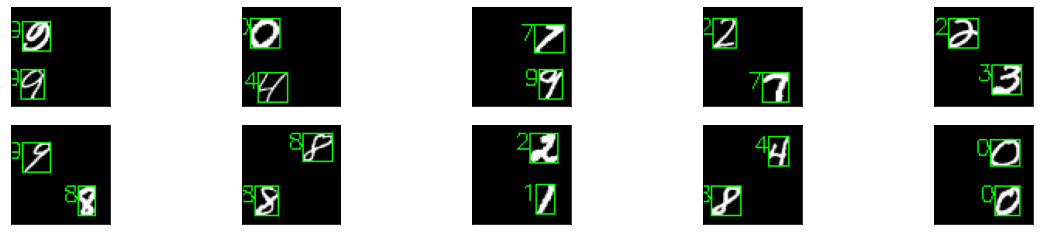

In [42]:
import cv2
plt.figure(figsize=(20,4))
for k in range(10):
  result = np.tile(x_train_obj[k,:,:,:],(1,1,3))

  for i in range(2):
    for j in range(2):
      object_present = np.round(y_train_obj[k,i,j,0])
      if object_present:
        class_index = np.argmax(y_train_obj[k,i,j,5:])
        xmin = int(y_train_obj[k,i,j,1] + i*32) # row
        ymin = int(y_train_obj[k,i,j,2] + j*32) # col
        xmax = int(y_train_obj[k,i,j,3] + i*32) # row
        ymax = int(y_train_obj[k,i,j,4] + j*32) # col
        cv2.rectangle(result,(ymin,xmin),(ymax,xmax),(0,255,0),1)
        cv2.putText(result, str(class_index), (ymin-10, xmin+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0),lineType=cv2.LINE_AA)
  ax = plt.subplot(2,5,k+1)
  plt.imshow(result)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

###Training
We are ready to start training the model.

In [49]:
objdet.fit(x_train_obj, y_train_obj, epochs=100, batch_size=128,shuffle=True,verbose=1)

Epoch 1/100
40/40 [==============================] - 1s 24ms/step - loss: 38.8273
Epoch 2/100
40/40 [==============================] - 1s 22ms/step - loss: 33.3952
Epoch 3/100
40/40 [==============================] - 1s 22ms/step - loss: 29.3092
Epoch 4/100
40/40 [==============================] - 1s 22ms/step - loss: 25.2456
Epoch 5/100
40/40 [==============================] - 1s 22ms/step - loss: 21.1503
Epoch 6/100
40/40 [==============================] - 1s 22ms/step - loss: 17.3743
Epoch 7/100
40/40 [==============================] - 1s 21ms/step - loss: 13.8651
Epoch 8/100
40/40 [==============================] - 1s 22ms/step - loss: 10.4723
Epoch 9/100
40/40 [==============================] - 1s 21ms/step - loss: 7.2810
Epoch 10/100
40/40 [==============================] - 1s 22ms/step - loss: 4.5188
Epoch 11/100
40/40 [==============================] - 1s 21ms/step - loss: 2.6089
Epoch 12/100
40/40 [==============================] - 1s 21ms/step - loss: 1.7369
Epoch 13/100
40/4

###Model evaluation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

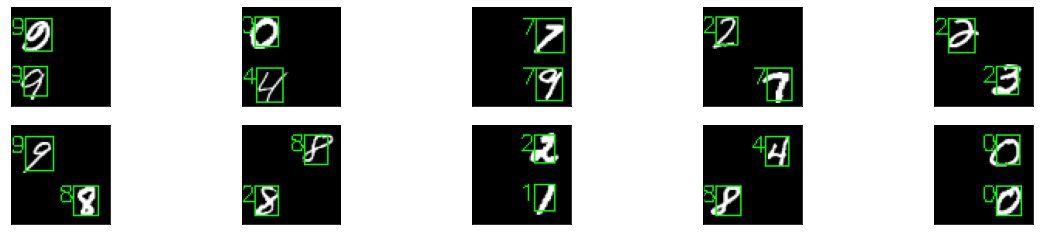

In [50]:
out = objdet.predict(x_train_obj[0:10,:,:,:])

plt.figure(figsize=(20,4))
for k in range(10):
  result = np.tile(x_train_obj[k,:,:,:],(1,1,3))

  for i in range(2):
    for j in range(2):
      object_present = np.round(out[k,i,j,0])
      if object_present:
        class_index = np.argmax(out[k,i,j,5:])
        xmin = int(out[k,i,j,1] + i*32) # row
        ymin = int(out[k,i,j,2] + j*32) # col
        xmax = int(out[k,i,j,3] + i*32) # row
        ymax = int(out[k,i,j,4] + j*32) # col
        cv2.rectangle(result,(ymin,xmin),(ymax,xmax),(0,255,0),1)
        cv2.putText(result, str(class_index), (ymin-10, xmin+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0),lineType=cv2.LINE_AA)
  ax = plt.subplot(2,5,k+1)
  plt.imshow(result)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

**Note:** Do not expect perfect results. Our object detection network is over-simplified compared to state-of-the-art. Or more precisely, the loss function is far from ideal, so we are optimizing *the wrong objective*, so to say.

##Task 9: Image segmentation
Image segmentation is a form of image-to-image transformation. It outputs a softmax classification per pixel. So if the input image has size 64x64, and there are 10 classes, the output will have shape 64x64x10. That is, for each pixel the network outputs a vector of class probabilities:

![alt text](https://miro.medium.com/max/498/1*P1ooLjeSwhxeJGyFawCvaQ.png)

Source of inspiration: https://medium.com/100-shades-of-machine-learning/https-medium-com-100-shades-of-machine-learning-rediscovering-semantic-segmentation-part1-83e1462e0805

Let's first make a new training set.

###Training images
The training images (x_train_seg) will be 64x64, where two of the four quadrants will contain one handwritten digit. This is to illustrate that we can teach a network to identify and segment more than one digit per input image.

The target output (`y_train_seg`) will be 64x64x10, with a one-hot vector for each pixel indicating the correct class.

In [51]:
x_train_seg = np.zeros((5000,64,64,1))
y_train_seg = np.zeros((5000,64,64,10))

for i in range(5000):
  
  ## 1
  q = np.random.randint(0,2) # 1st or 2nd image quadrant?
  rand_ix = np.random.randint(0,x_train.shape[0])
  x_off_start = np.random.randint(0,5)
  y_off_start = np.random.randint(0,5)
  x_train_seg[i,0+x_off_start:28+x_off_start,32*q+y_off_start:32*q+28+y_off_start,:] = x_train[rand_ix,:,:,:]

  # Mask
  tmp = x_train[rand_ix,:,:,:]
  ix = np.where(tmp>0.1)
  tmp = np.zeros(tmp.shape)
  tmp[ix] = 1
  label = np.argmax(y_train[rand_ix,:])
  y_train_seg[i,0+x_off_start:28+x_off_start,32*q+y_off_start:32*q+28+y_off_start,label] = tmp.squeeze()
  
  ## 2
  q = np.random.randint(0,2) #  3rd or 4th image quadrant?
  rand_ix = np.random.randint(0,x_train.shape[0])
  x_off_start = np.random.randint(0,5)
  y_off_start = np.random.randint(0,5)
  x_train_seg[i,32+x_off_start:32+28+x_off_start,32*q+y_off_start:32*q+28+y_off_start,:] = x_train[rand_ix,:,:,:]

  # Mask
  tmp = x_train[rand_ix,:,:,:]
  ix = np.where(tmp>0.1)
  tmp = np.zeros(tmp.shape)
  tmp[ix] = 1
  label = np.argmax(y_train[rand_ix,:])
  y_train_seg[i,32+x_off_start:32+28+x_off_start,32*q+y_off_start:32*q+28+y_off_start,label] = tmp.squeeze()

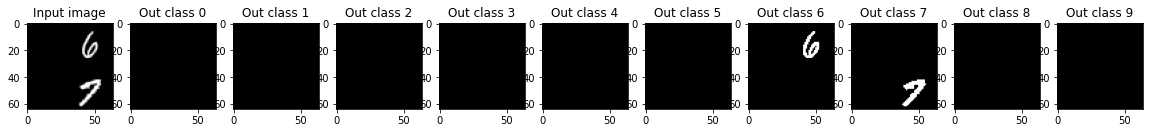

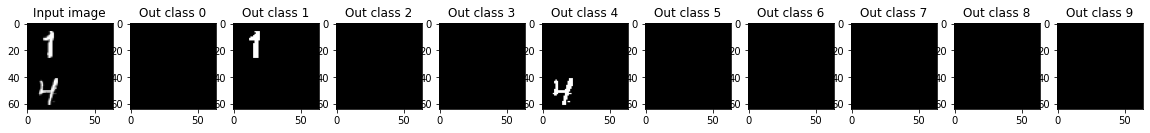

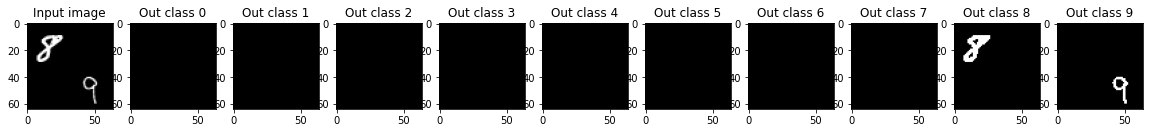

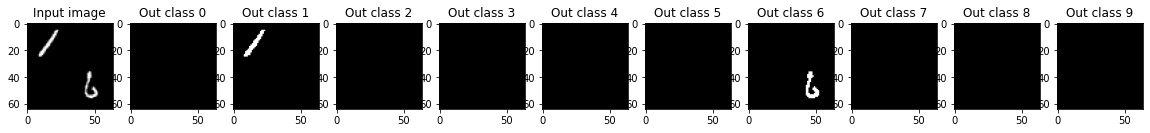

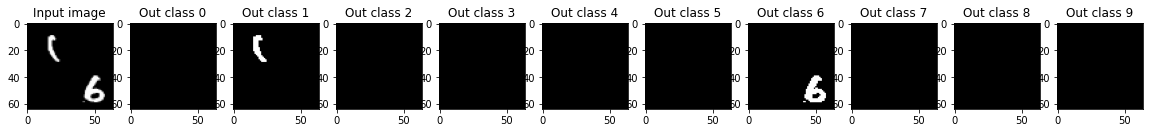

In [52]:
# Show examples of input to output mappings
for ex in range(5):
  plt.figure(figsize=(20,6))
  rand_ix = np.random.randint(0,5000)
  ax = plt.subplot(1,11,1)
  plt.imshow(x_train_seg[rand_ix,:,:,:].squeeze())
  plt.title('Input image')
  for i in range(10):
    ax = plt.subplot(1,11,i+2)
    plt.imshow(y_train_seg[rand_ix,:,:,i].squeeze())
    plt.title("Out class "+str(i))

###U-Net for image segmentation
We will use a light version of the so-called U-Net:
- https://arxiv.org/pdf/1505.04597.pdf
- https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47

![alt text](https://miro.medium.com/max/720/1*OkUrpDD6I0FpugA_bbYBJQ.png)

In [53]:
from keras.layers import concatenate

# See last layer of network
def softMaxAxis3(x):
    return softmax(x,axis=3)

inputs = Input(shape=(64, 64, 1))

# Encoder
conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)

# Decoder
up7 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop4))
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
up8 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
up9 = Conv2D(8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

# Perform softmax on each pixel, so axis should be 3 because output has shape: batch_size x 64 x 64 x num_classes
conv10 = Conv2D(num_classes, 1, activation = softMaxAxis3)(conv9)

model = Model(inputs, conv10)
model.summary()
model.compile(optimizer = keras.optimizers.RMSprop(lr = 1e-3), loss = 'binary_crossentropy')

Model: "functional_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 64, 64, 8)    80          input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 64, 64, 8)    584         conv2d_59[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_39 (MaxPooling2D) (None, 32, 32, 8)    0           conv2d_60[0][0]                  
______________________________________________________________________________________

###Questions 9.1
1. What does "concatenate" do?
2. Which layers of the encoder are being concated with which layers of the decoder?
3. Why do you think U-Net concatenates outputs from layers of the encoder and layers of the decoder?

Hint: Use K.int_shape(...) to get the shapes of the layers that are being concatenated

###Answers
1. It merges two or more layers along a specified axis. For instance

```
conv3 (None, 16, 16, 32)
and
up7 (None, 16, 16, 32)
are merged into
merge7 (None, 16, 16, 64)
```

2. Layers are being paired from either end of the network. First convolutional layer goes with last upsamling layer (merge9 = conv1 + up9), second convolutional layer goes with second to last upsampling layer (merge8 = conv2 + up8), etc.
3. As the input image gets processed through the convolutional layers of the encoder, the spatial resolution is decreased, and information about fine image details is therefore lost. With the concatenation layers, high spatial information from encoder layers are feed directly to the decoder layers, helping it to reconstruct an output that maintain fine image details. See for yourself in the example below, where the concat layers have been removed.



In [54]:
# merge7 = concatenate([conv3,up7], axis = 3)
print('conv3',K.int_shape(conv3))
print('up7',K.int_shape(up7))
print('merge7',K.int_shape(merge7))
# merge8 = concatenate([conv2,up8], axis = 3)
print('conv2',K.int_shape(conv2))
print('up8',K.int_shape(up8))
print('merge8',K.int_shape(merge8))
# merge9 = concatenate([conv1,up9], axis = 3)
print('conv1',K.int_shape(conv1))
print('up9',K.int_shape(up9))
print('merge9',K.int_shape(merge9))

conv3 (None, 16, 16, 32)
up7 (None, 16, 16, 32)
merge7 (None, 16, 16, 64)
conv2 (None, 32, 32, 16)
up8 (None, 32, 32, 16)
merge8 (None, 32, 32, 32)
conv1 (None, 64, 64, 8)
up9 (None, 64, 64, 8)
merge9 (None, 64, 64, 16)


###Training

In [55]:
model.fit(x_train_seg, y_train_seg, epochs=30, batch_size=64, shuffle=True, verbose=1)

Epoch 1/30
79/79 [==============================] - 6s 70ms/step - loss: 0.1196
Epoch 2/30
79/79 [==============================] - 5s 66ms/step - loss: 0.1169
Epoch 3/30
79/79 [==============================] - 5s 66ms/step - loss: 0.1139
Epoch 4/30
79/79 [==============================] - 5s 66ms/step - loss: 0.1116
Epoch 5/30
79/79 [==============================] - 5s 66ms/step - loss: 0.1097
Epoch 6/30
79/79 [==============================] - 5s 66ms/step - loss: 0.1079
Epoch 7/30
79/79 [==============================] - 5s 66ms/step - loss: 0.1065
Epoch 8/30
79/79 [==============================] - 5s 66ms/step - loss: 0.1054
Epoch 9/30
79/79 [==============================] - 5s 66ms/step - loss: 0.1044
Epoch 10/30
79/79 [==============================] - 5s 66ms/step - loss: 0.1036
Epoch 11/30
79/79 [==============================] - 5s 66ms/step - loss: 0.1031
Epoch 12/30
79/79 [==============================] - 5s 66ms/step - loss: 0.1026
Epoch 13/30
79/79 [==================

###Model evaluation

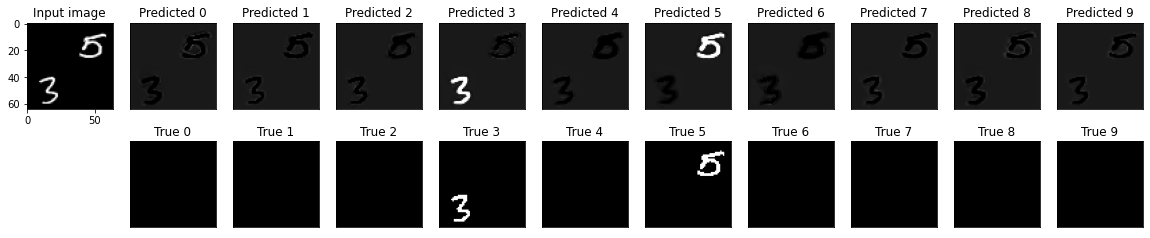

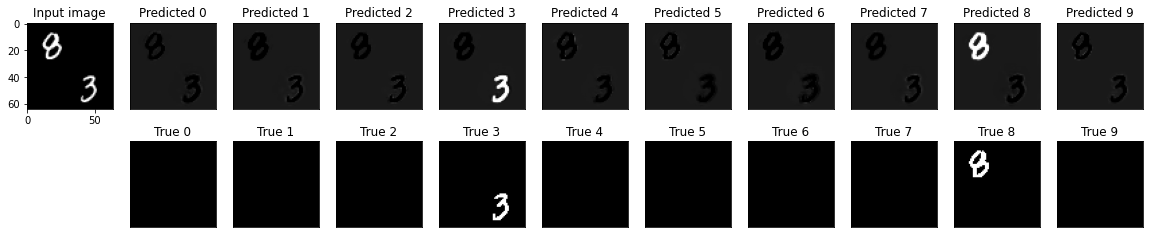

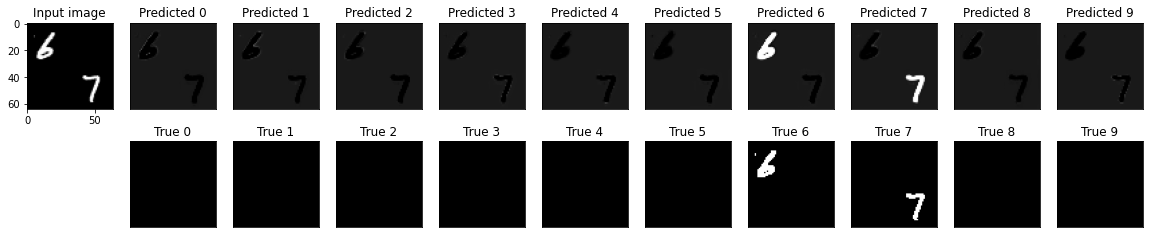

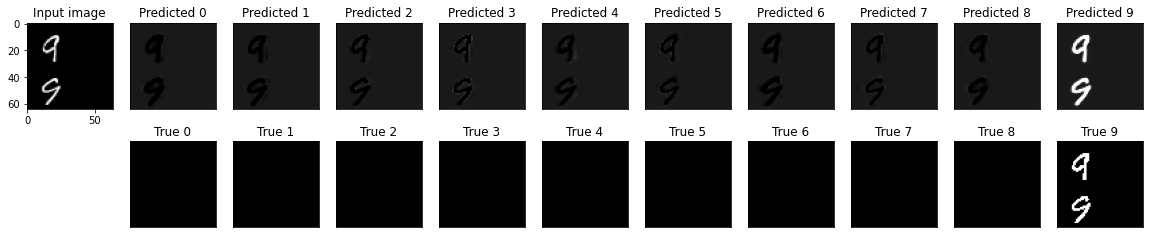

In [56]:
# Pick 4 random examples
rand_ix = np.random.randint(0,5000,4)
out = model.predict(x_train_seg[rand_ix,:,:,:])
ref = y_train_seg[rand_ix,:,:,:].squeeze()
for k in range(4):
  plt.figure(figsize=(20,4))
  plt.subplot(2,11,1)
  plt.imshow(x_train_seg[rand_ix[k],:,:,:].squeeze())
  plt.title('Input image')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  for i in range(10):
    ax = plt.subplot(2,11,i+2)
    plt.imshow(out[k,:,:,i].squeeze(),vmin=0,vmax=1)
    plt.title('Predicted ' + str(i))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2,11,11+i+2)
    plt.imshow(ref[k,:,:,i].squeeze(),vmin=0,vmax=1)
    plt.title('True ' + str(i))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

###Task 9.1
Remove the concatenation layers (i.e., fill in the empty slots marked with ???). Then run the code block and train the model.

In [ ]:
inputs = Input(shape=(64, 64, 1))

# Encoder
conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)

# Decoder
up7 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop4))
#merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(???)
conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
up8 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
#merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(???)
conv8 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
up9 = Conv2D(8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
#merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(???)
conv9 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

# Perform softmax on each pixel, so axis should be 3 because output has shape: batch_size x 64 x 64 x num_classes
conv10 = Conv2D(num_classes, 1, activation = softMaxAxis3)(conv9)

model = Model(input = inputs, output = conv10)
model.summary()
model.compile(optimizer = keras.optimizers.RMSprop(lr = 1e-3), loss = 'binary_crossentropy')

###Solution

In [57]:
inputs = Input(shape=(64, 64, 1))

# Encoder
conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)

# Decoder
up7 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop4))
#merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up7)
conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
up8 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
#merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up8)
conv8 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
up9 = Conv2D(8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
#merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up9)
conv9 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

# Perform softmax on each pixel, so axis should be 3 because output has shape: batch_size x 64 x 64 x num_classes
conv10 = Conv2D(num_classes, 1, activation = softMaxAxis3)(conv9)

model = Model(inputs, conv10)
model.compile(optimizer = keras.optimizers.RMSprop(lr = 1e-3), loss = 'binary_crossentropy')

###Training
Train the model

In [58]:
model.fit(x_train_seg, y_train_seg, epochs=30, batch_size=64, shuffle=True, verbose=1)

Epoch 1/30
79/79 [==============================] - 5s 63ms/step - loss: 0.1200
Epoch 2/30
79/79 [==============================] - 5s 62ms/step - loss: 0.1197
Epoch 3/30
79/79 [==============================] - 5s 62ms/step - loss: 0.1185
Epoch 4/30
79/79 [==============================] - 5s 62ms/step - loss: 0.1172
Epoch 5/30
79/79 [==============================] - 5s 62ms/step - loss: 0.1154
Epoch 6/30
79/79 [==============================] - 5s 62ms/step - loss: 0.1132
Epoch 7/30
79/79 [==============================] - 5s 62ms/step - loss: 0.1116
Epoch 8/30
79/79 [==============================] - 5s 62ms/step - loss: 0.1102
Epoch 9/30
79/79 [==============================] - 5s 62ms/step - loss: 0.1091
Epoch 10/30
79/79 [==============================] - 5s 62ms/step - loss: 0.1082
Epoch 11/30
79/79 [==============================] - 5s 62ms/step - loss: 0.1075
Epoch 12/30
79/79 [==============================] - 5s 62ms/step - loss: 0.1070
Epoch 13/30
79/79 [==================

###Model evaluation

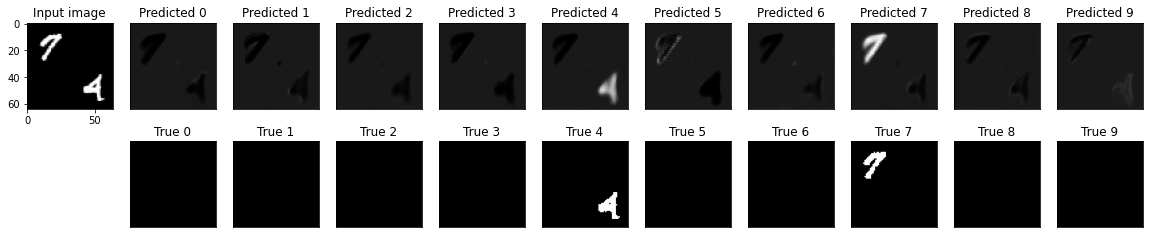

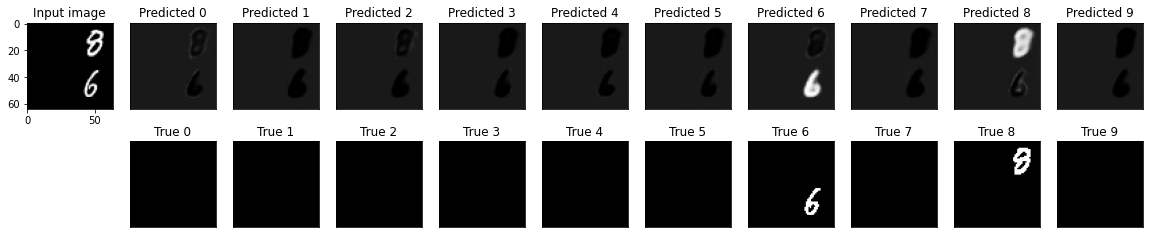

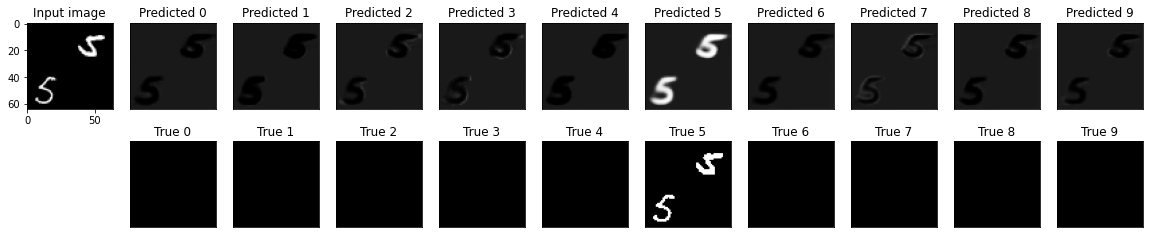

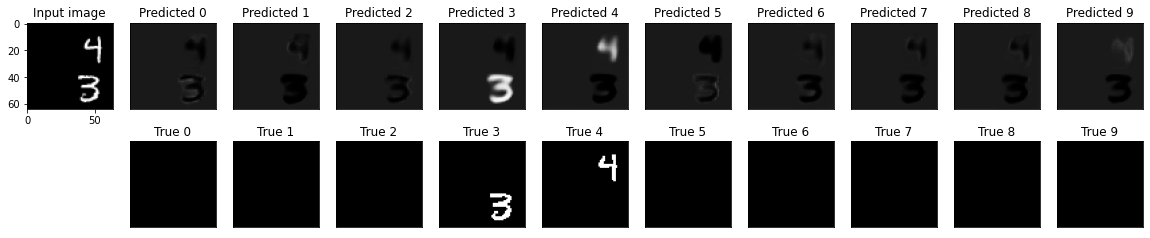

In [59]:
# Pick 4 random examples
rand_ix = np.random.randint(0,5000,4)
out = model.predict(x_train_seg[rand_ix,:,:,:])
ref = y_train_seg[rand_ix,:,:,:].squeeze()
for k in range(4):
  plt.figure(figsize=(20,4))
  plt.subplot(2,11,1)
  plt.imshow(x_train_seg[rand_ix[k],:,:,:].squeeze())
  plt.title('Input image')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  for i in range(10):
    ax = plt.subplot(2,11,i+2)
    plt.imshow(out[k,:,:,i].squeeze(),vmin=0,vmax=1)
    plt.title('Predicted ' + str(i))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2,11,11+i+2)
    plt.imshow(ref[k,:,:,i].squeeze(),vmin=0,vmax=1)
    plt.title('True ' + str(i))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

###Questions 9.2
1. Results look more blurry without the concatenation layers. Why?

###Answers
1. Fine image details are lost in the convolution layers of the encoder, as explained above.

##10 Ideas for further work:
###Few-shot learning (or one-shot learning) with Siamese networks
What? Why? How?

Can you modify the code below to train on just 10 examples of each class?

Read here: https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d

Code here: https://keras.io/examples/mnist_siamese/

In [ ]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np

import random
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.optimizers import RMSprop
from keras import backend as K

num_classes = 10
epochs = 20

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)

def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    return Model(input, x)

def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
input_shape = x_train.shape[1:]

# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

# train
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

###Solution
A siamese takes not *one*, but two images as input (`A` and `B`). Both images are passed through the same encoder (`E`) to obtain feature vectors:

```
a = E(A)
b = E(b)
```

The decoder is then trained to predict whether the two input images are of the same class or not, based on the feature vectors a and b. Therefore the training set consists of an even number of pairs of images of "same class" and "not same class".

Essentially what a siamese network learns is a distance metric

```
D(a,b)
```

such that `D(a,b)` is small if `A` and `B` are of the same class, and large if they are not of the same class.

In [ ]:
# create smaller training set
digit_indices = np.asarray([np.where(np.argmax(y_train,axis=1) == i)[0][np.random.randint(0,5000,10)] for i in range(num_classes)]).flatten()
x_train_small = x_train[digit_indices,:]
y_train_small = y_train[digit_indices,:]

In [ ]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np

import random
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.optimizers import RMSprop
from keras import backend as K

num_classes = 10
#epochs = 20
epochs = 200

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)

def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    return Model(input, x)

def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
input_shape = x_train.shape[1:]

# create training+test positive and negative pairs
#digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
num_samples = 10
digit_indices = [np.where(y_train == i)[0][np.random.randint(0,5000,num_samples)] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

#digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
digit_indices = [np.where(y_test == i)[0][np.random.randint(0,800,num_samples)] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

# train
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

###Generative Adversarial Networks
What on earth is this thing doing? See if you can guess :-)

Read here: https://towardsdatascience.com/dcgans-deep-convolutional-generative-adversarial-networks-c7f392c2c8f8

Code here: https://github.com/eriklindernoren/Keras-GAN/blob/master/dcgan/dcgan.py

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_102 (Conv2D)          (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 64)         

<Figure size 432x288 with 0 Axes>

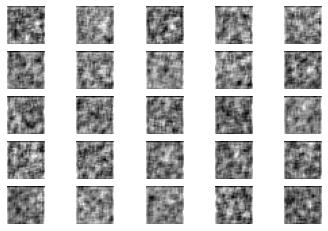

500 [D loss: 0.177657, acc.: 96.88%] [G loss: 0.907905]


<Figure size 432x288 with 0 Axes>

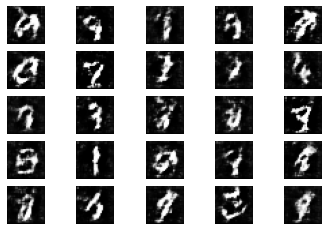

1000 [D loss: 0.000229, acc.: 100.00%] [G loss: 5.419037]


<Figure size 432x288 with 0 Axes>

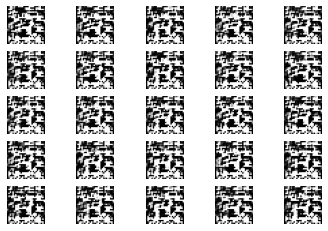

1500 [D loss: 0.000008, acc.: 100.00%] [G loss: 4.012588]


<Figure size 432x288 with 0 Axes>

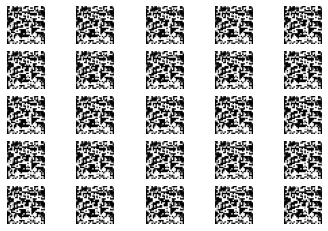

2000 [D loss: 0.000005, acc.: 100.00%] [G loss: 3.592969]


<Figure size 432x288 with 0 Axes>

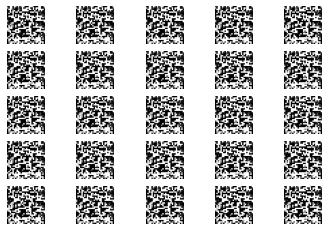

2500 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.189548]


<Figure size 432x288 with 0 Axes>

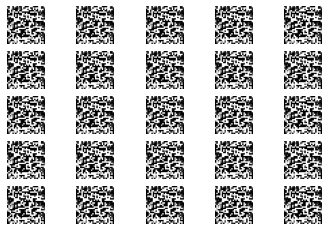

3000 [D loss: 0.000003, acc.: 100.00%] [G loss: 3.235473]


<Figure size 432x288 with 0 Axes>

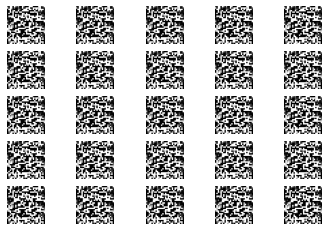

3500 [D loss: 0.000001, acc.: 100.00%] [G loss: 2.858639]


<Figure size 432x288 with 0 Axes>

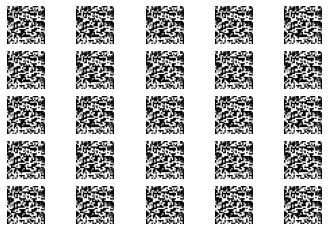

KeyboardInterrupt: ignored

In [62]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt

import sys

class DCGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 10

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=500):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            #print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        plt.figure()
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        #fig.savefig("mnist_%d.png" % epoch)
        plt.show()

if __name__ == '__main__':
    dcgan = DCGAN()
    dcgan.train(epochs=4000, batch_size=32, save_interval=500)

###Explanation
DCGAN is short for Deep Convolutional Generative Adversarial Networks. A DCGAN is a generative model that learns to map random noise vectors into images. Unlike an autoencoder, which  encodes and decodes an image into itself, DCGAN learns to generate images that look real. This means that you must have a data set of real images to compare with.

The network consists of two sub-networks that are trained in tandem:

- The **Generator** takes a random noise vector and maps it into an image.
- The **Discriminator** takes an input image, which is either **"real"** (i.e., picked from the database of real images) or **"fake"** (i.e., generated by the Generator). It then learns to distingiush between real and fake images.

The two networks are competing against each other, and at some point the Generator becomes so good at generating fakes, which look real, that the Discriminator can no longer distuingish fakes from reals.

GANs are really hard to train and the above example is just a toy example.